In [7]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection as model_selection
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N1, N2, N3 = 6, 6, 288 
K, D = 3, 2

X = np.vstack((
    np.random.randn(N1,D) + np.array([2,2]),
    np.random.randn(N2,D) + np.array([2,-2]),
    np.random.randn(N3,D) + np.array([-2,0])
))

y = np.array([0]*N1 + [1]*N2 + [2]*N3)

DF = pd.DataFrame(np.column_stack((y,X)), columns=['target','x','y'])

In [3]:
def check_for_imbalanced_data(DF, **kwargs):
    """Checks the array is imbalanced. Returns a dictionary with the answer and its bincount."""

    # options
    threshold = kwargs['threshold'] if 'threshold' in kwargs else 0.2
    verbose = kwargs['verbose'] if 'verbose' in kwargs else True
    column = kwargs['column'] if 'column' in kwargs else 'target'
    
    y = DF.target.to_numpy(np.int32)
    assert y.shape[0] == y.size, "to bincounts, input array must be 1D" # check input

    bincount = np.bincount(y) # how many observations for each unique value
    unique = np.unique(y) # find all the unique values
    N = y.shape[0] # total number of observations

    for i,v in enumerate(unique):
        assert y[y==v].size == bincount[i], "for some reason, the unique values and the bincounts don't match"

    imbalanced = np.any(bincount/N < threshold) # find out if the data is imbalanced
    if verbose:
        print("\nchecking if data is imbalanced...")
        if imbalanced:
            print(f"data is imbalanced (threshold = {threshold})")
        else:
            print(f"data is not imbalanced (threshold = {threshold})")

        print("unique values line up with bincounts")

    # sort bincount and uniques
    idx = bincount.argsort() # find the indicies to sort bincount

    return {'imbalanced':imbalanced, 'bincount':bincount[idx], 'unique':unique[idx]}

def train_test_split_indices(DF, **kwargs):
    """Returns the indicies for the train, validate, and test sets as a dictionary with keys: 'train', 'validate', and 'test', with int32 numpy arrays as their values."""

    # options
    shuffle = kwargs['shuffle'] if 'shuffle' in kwargs else True
    seed = kwargs['seed'] if 'seed' in kwargs else 0
    train_size = kwargs['train_size'] if 'train_size' in kwargs else 0.6
    validate_size = kwargs['validate_size'] if 'validate_size' in kwargs else 0.2
    stratify = kwargs['stratify'] if 'stratify' in kwargs else False
    verbose = kwargs['verbose'] if 'verbose' in kwargs else True

    check = check_for_imbalanced_data(DF, **kwargs) # run a check to see if data is imbalanced

    if verbose:
        print("\nSplitting data into train validate test sets...")
        if check['imbalanced'] and stratify == False:
            print("Data may be imbalanced, consider stratifying data.")
        else:
            print("Stratifying data...")
            
    N = DF.shape[0] # find number of indicies

    if stratify:

        idx = np.arange(N)
        indices = {
            'train'    : np.array([], dtype=np.int32),
            'validate' : np.array([], dtype=np.int32),
            'test'     : np.array([], dtype=np.int32)
        }

        for i,(value,count) in enumerate(zip(check['unique'],check['bincount'])):
            idx1 = idx[ y == value ]
            N1 = idx1.size
            assert N1 == count, "For some reason, the counts don't line up."
            N_train = int(N1*train_size)
            N_validate = int(N1*validate_size)
            indices['train'] = np.hstack(( indices['train'], idx1[:N_train] ))
            indices['validate'] = np.hstack(( indices['validate'], idx1[N_train:N_train+N_validate]))
            indices['test'] = np.hstack(( indices['test'], idx1[N_train+N_validate:]))

        if shuffle:
            for key in ['train', 'validate', 'test']:
                np.random.RandomState(seed=seed).shuffle(indices[key])

    else:
        N_train = int(N*train_size)
        N_validate = int(N*validate_size)
        if shuffle:
            idx = np.random.RandomState(seed=seed).permutation(N)
        else:
            idx = np.arange(N)
        indices = {
            'train'    : idx[ : N_train ],
            'validate' : idx[ N_train : N_train + N_validate ],
            'test'     : idx[ N_train + N_validate : ]
        }

    return indices

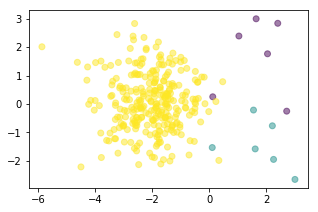

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(DF.x, DF.y, c=DF.target, alpha=.5)
ax.set_aspect(1)

time: 6246.0000 microseconds


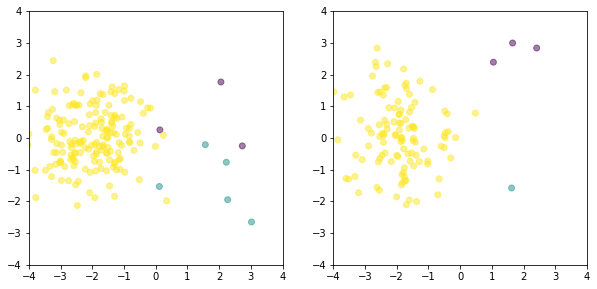

In [16]:
t0 = datetime.now()
DF1,DF2,t1,t2 = model_selection.train_test_split(DF[['x','y']],DF.target, train_size=.6, test_size=.4)
dt = datetime.now() - t0
print(f"time: {dt.microseconds:0.4f} microseconds")

fig,ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(DF1.x, DF1.y, c=t1, alpha=.5)
ax[1].scatter(DF2.x, DF2.y, c=t2, alpha=.5)
for i in range(2):
    ax[i].set_aspect(1)
    ax[i].set_xlim((-4,4))
    ax[i].set_ylim((-4,4))

time: 1970.0000 microseconds


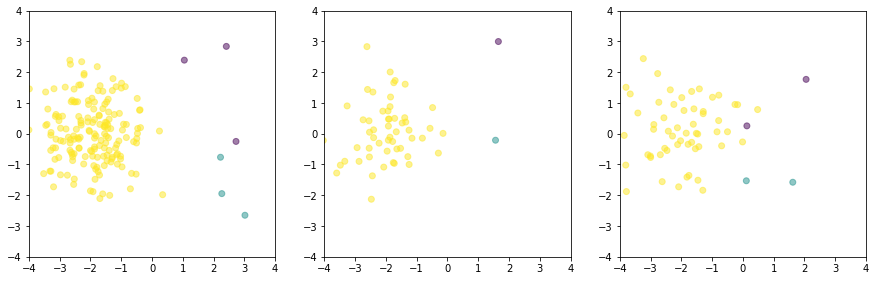

In [17]:
t0 = datetime.now()
split = train_test_split_indices(DF, stratify=True, verbose=False)
dt = datetime.now() - t0
print(f"time: {dt.microseconds:0.4f} microseconds")

fig,ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(DF.loc[split['train'],'x'], DF.loc[split['train'],'y'], c=DF.loc[split['train'],'target'], alpha=.5)
ax[1].scatter(DF.loc[split['validate'],'x'], DF.loc[split['validate'],'y'], c=DF.loc[split['validate'],'target'], alpha=.5)
ax[2].scatter(DF.loc[split['test'],'x'], DF.loc[split['test'],'y'], c=DF.loc[split['test'],'target'], alpha=.5)
for i in range(3):
    ax[i].set_aspect(1)
    ax[i].set_xlim((-4,4))
    ax[i].set_ylim((-4,4))

In [18]:
DF.head()

,target,x,y
0,0.0,2.414474,2.837531
1,0.0,2.729000,-0.250629
2,0.0,1.049294,2.390719
3,0.0,1.655172,2.995763
4,0.0,2.055163,1.765846


In [19]:
DF.iloc[np.array([0,4,2])]

,target,x,y
0,0.0,2.414474,2.837531
4,0.0,2.055163,1.765846
2,0.0,1.049294,2.390719
